In [1]:
import pandapower as pp
from pandapower import runpp
from pandapower.plotting import simple_plotly, pf_res_plotly
import pandapower.networks as networks
from citylearn import CityLearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import random

In [2]:
class GridLearn(CityLearn):
    def __init__(self, data_path, building_attributes, weather_file, solar_profile, building_ids, buildings_states_actions = None, simulation_period = (0,8759), cost_function = ['ramping','1-load_factor','average_daily_peak', 'peak_demand','net_electricity_consumption'], central_agent = False, verbose = 0, n_buildings_per_bus=4):
        self.net = self.make_grid()
        n_buildings = n_buildings_per_bus * (len(self.net.bus)-1)
        super().__init__(data_path, building_attributes, weather_file, solar_profile, building_ids, buildings_states_actions, simulation_period, cost_function, central_agent, verbose, n_buildings)
        self.house_nodes = self.add_houses(n_buildings_per_bus)
        # for some reason it seems like the output_writer for panda power only applies to deterministic time series
        self.output = {'p_mw_load':{'var':'p_mw', 'parent':'res_load', 'values':pd.DataFrame()},
           'q_mvar_gen':{'var':'q_mvar', 'parent':'res_gen', 'values':pd.DataFrame()},
           'vm_pu':{'var':'vm_pu', 'parent':'res_bus', 'values':pd.DataFrame()},
           'i_ka':{'var':'i_ka', 'parent':'res_line', 'values':pd.DataFrame()},
           'p_mw_stor':{'var':'p_mw', 'parent':'res_storage', 'values':pd.DataFrame()},
           'p_mw_gen':{'var':'p_mw', 'parent':'res_gen', 'values':pd.DataFrame()}}
    
    def make_grid(self):
        # make a grid that fits the buildings generated for CityLearn
        net = networks.case33bw()
        return net
    
    def add_houses(self, n):
        houses = []
        b = 0
        
        # find nodes in the network with residential voltage levels and load infrastructure
        # get the node indexes by their assigned names
        load_nodes = self.net.load['bus']
        res_voltage_nodes = self.net.bus['name'][self.net.bus['vn_kv'] == 12.66]
        res_load_nodes = set(load_nodes) & set(res_voltage_nodes)
        
        # add a residential distribution feeder type to the PandaPower network
        # Assume for now ~250A per home on "94-AL1/15-ST1A 0.4" lines rated @ 350A
        
        # for geometric placement of nodes
        delta_x = 0.2
        delta_y = 0.2
        
        all_buildings = list(self.buildings.keys())
        
        for existing_node in res_load_nodes:
            # remove the existing arbitrary load
            self.net.load.drop(self.net.load[self.net.load.bus == existing_node].index, inplace=True)
            
            # get geodata of this load
            existing_x = self.net.bus_geodata['x'][existing_node]
            existing_y = self.net.bus_geodata['y'][existing_node]
        
            # add n houses at each of these nodes
            for i in range(n):
                bid = all_buildings[b] # get a building in the order they were initialized
                b += 1
                new_x = existing_x + np.cos(2 * np.pi/n * i) * delta_x
                new_y = existing_y + np.sin(2 * np.pi/n * i) * delta_y
                new_house = pp.create_bus(self.net, name=bid, vn_kv=12.66, max_vm_pu=1.2, min_vm_pu=0.8, zone=1, geodata=(new_x, new_y))
                new_feeder = pp.create_line(self.net, new_house, existing_node, 0.5, "94-AL1/15-ST1A 0.4", max_loading_percent=100)
                new_house_load = pp.create_load(self.net, new_house, 0, name=bid)
                
                if np.random.randint(2) == 0:
                    rated_sn_mva = np.max(np.amax(np.reshape(self.buildings[bid].sim_results['solar_gen'],(24,-1)), axis=0))
                    new_house_pv = pp.create_gen(self.net, new_house, 0.0, name=bid, sn_mva=rated_sn_mva)
                houses += [new_house]
        return houses
        
    # Change to citylearn.py: get_cvr_electricty_demand is called to determine kW opposed to kVA
    def get_cvr_electricty_demand(self):
        electricity_demand = np.array(self.net.p_mw)
        total_electricity_demand = -1 * np.sum(electricity_demand)
        return list(np.sign(electricity_demand)*0.01*(np.array(np.abs(electricity_demand))**2 * max(0, total_electricity_demand)))
    
    # Change to citylearn.py: aux_grid_function is called at the end of .step()   
    def aux_grid_func(self):
        for i in self.net.load.index:
            current_load = 0
            h = self.net.load.name[i]
            current_load += self.buildings[h].get_dhw_electric_demand() * 0.001
            current_load += self.buildings[h].get_non_shiftable_load() * 0.001
            current_load += self.buildings[h].get_cooling_electric_demand() * 0.001
            self.net.load.at[i, 'p_mw'] = 0.9 * current_load
            self.net.load.at[i, 'sn_mva'] = current_load
            
        for j in self.net.gen.index:
            h = self.net.gen.name[j]
            current_gen = self.buildings[h].solar_power * 0.001
            self.net.gen.at[j, 'p_mw'] = 0.9 * current_gen
            self.net.gen.at[j, 'sn_mva'] = current_gen
            self.net.gen.at[j, 'min_p_mw'] = 0 #-1 * current_gen
            self.net.gen.at[j, 'max_p_mw'] = current_gen
            self.net.gen.at[j, 'min_q_mvar'] = -1 * current_gen
            self.net.gen.at[j, 'max_q_mvar'] = current_gen
    
#         pp.create_poly_cost(self.net, 0, "ext_grid", cp1_eur_per_mw=0, cp2_eur_per_mw2=1)
#         pp.runopp(self.net, verbose=True) # dont use the opp since control decisions are made by the citylearn RL agent(s)
        runpp(self.net, enforce_q_lims=True)
    
        # write these value to the output writer:
        for k, v in self.output.items():
            self.output[k]['values'][str(self.time_step)] = self.net[v['parent']][v['var']]
            
    def plot_buses(self):
        df = self.output['vm_pu']['values']
        xfmr = set(self.net.bus.iloc[self.net.trafo.hv_bus].index) | set(self.net.bus.iloc[self.net.trafo.lv_bus].index)
        ext_grid = set(self.net.bus.iloc[self.net.ext_grid.bus].index)
        substation = xfmr | ext_grid
        loads = set(self.net.load.bus)
        buses = set(self.net.bus.index) - substation
        gens = set(self.net.gen.bus)

        # substation buses
        self.plot_northsouth([df.loc[substation]], title="Substation Voltages", y="Vm_pu")

        # generator buses
        gen_buses = gens & buses
        non_gen_buses = gens ^ buses
        if not len(gen_buses) == 0:
            self.plot_northsouth([df.loc[gen_buses]], title="Buses with PV", y="Vm_pu")

        # buses with building loads
        building_ng_buses = non_gen_buses & loads
        if not len(building_ng_buses) == 0:
            self.plot_northsouth([df.loc[building_ng_buses]], title="Building Voltages", y="Vm_pu")

        # other buses (distribution strictly)
        other_ng_buses = non_gen_buses - building_ng_buses
        if not len(other_ng_buses) == 0:
            self.plot_northsouth([df.loc[other_ng_buses]], title="Distribution buses", y="Vm_pu")
            
    def plot_northsouth(self, dfs, title="", y=""):
        line = self.net.bus_geodata['x'].median()
        
        temp = self.net.bus_geodata.merge(self.net.bus, left_index=True, right_index=True)
        north_buses = set(temp.loc[temp["x"] > line].index)
        south_buses = set(temp.loc[temp["x"] <= line].index)

        fig, axes = plt.subplots(nrows=len(dfs),ncols=2, figsize=(20,8))
        plt.subplots_adjust(hspace = 0.5, wspace=0.25)
        for i in range(len(dfs)): # can pass p and q vars
            north_list = set(dfs[i].index) & north_buses
            south_list = set(dfs[i].index) & south_buses

            if len(south_list) > 0:
                if len(dfs) > 1:
                    quad = axes[i][0]
                else:
                    quad = axes[0]
    
                f = dfs[i].loc[south_list].transpose().plot(ax=quad, figsize=(10,6), color=plt.cm.Spectral(np.linspace(0, 1, len(dfs[i]))))
                f.set_xlabel("Time (Hour)")
                f.set_ylabel(y[i])
                f.set_title(f"South, {title}")
                quad.legend().set_visible(False)

            if len(north_list) > 0:
                if len(dfs) > 1:
                    quad = axes[i][1]
                else:
                    quad = axes[1]

                g = dfs[i].loc[north_list].transpose().plot(ax=quad, figsize=(10,6), color=plt.cm.Spectral(np.linspace(1, 0, len(dfs[i]))))
                g.set_xlabel("Time (Hour)")
                g.set_ylabel(y[i])
                g.set_title(f"North, {title}")
                quad.legend().set_visible(False)
    
    def plot_all(self):
        self.plot_buses()
        self.plot_northsouth([self.output['p_mw_load']['values']], title="Building loads", y=["P (MW)"])
        self.plot_northsouth([self.output['p_mw_gen']['values'], self.output['q_mvar_gen']['values']], title="Generation", y=["P (MW)", "Q (MVAR)"])

In [3]:
np.random.seed(0)
climate_zone = 1
data_path = Path("data/Climate_Zone_"+str(climate_zone))
building_attributes = data_path / 'building_attributes.json'
weather_file = data_path / 'weather_data.csv'
solar_profile = data_path / 'solar_generation_1kW.csv'
building_state_actions = 'buildings_state_action_space.json'
building_ids = ["Building_1","Building_2","Building_3","Building_4","Building_5","Building_6","Building_7","Building_8","Building_9","Building_10"] # no generation output
# building_ids = ["Building_1"] # generators produce p_mw
objective_function = ['ramping','1-load_factor','average_daily_peak','peak_demand','net_electricity_consumption']
my_grid = GridLearn(data_path, building_attributes, weather_file, solar_profile, building_ids, buildings_states_actions = building_state_actions, cost_function = objective_function, verbose=1, n_buildings_per_bus=1)

In [4]:
observations_spaces, actions_spaces = my_grid.get_state_action_spaces()

# Simulation without energy storage
my_grid.reset()
done = False
# while not done:
for ts in range(12):
    # for the do nothing action:
    _, rewards, done, _ = my_grid.step([[0 for _ in range(actions_spaces[i].shape[0])] for i in range(len(my_grid.buildings))])
    
#     # for randomized actions:
#     _, rewards, done, _ = my_grid.step([actions_spaces[i].sample() for i in range(len(my_grid.buildings))])
    

In [5]:
cost_no_es = my_grid.cost()

In [6]:
pf_res_plotly(my_grid.net)
print()

In [7]:
actions_spaces[0].shape[0]

2

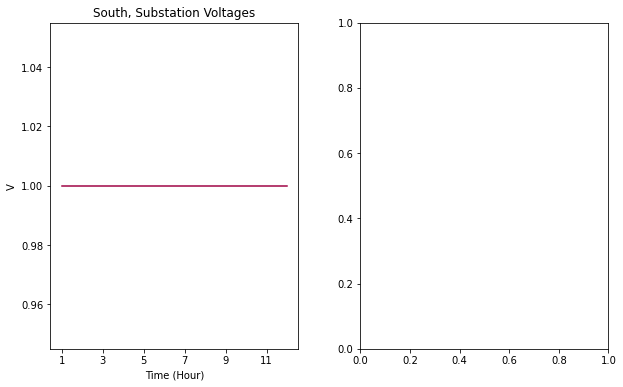

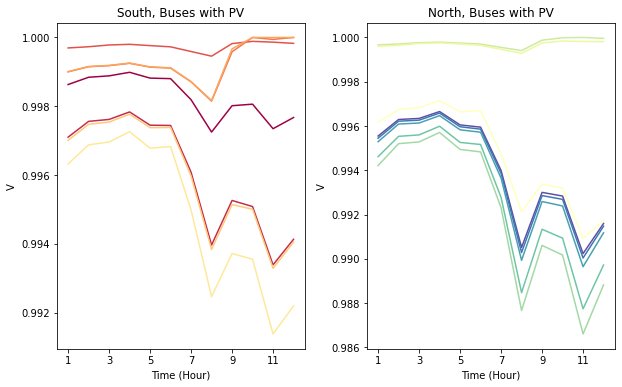

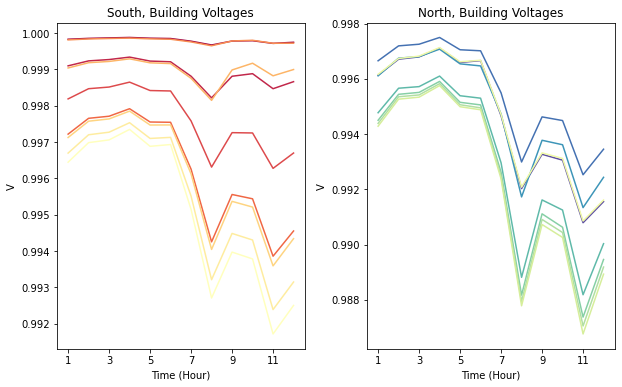

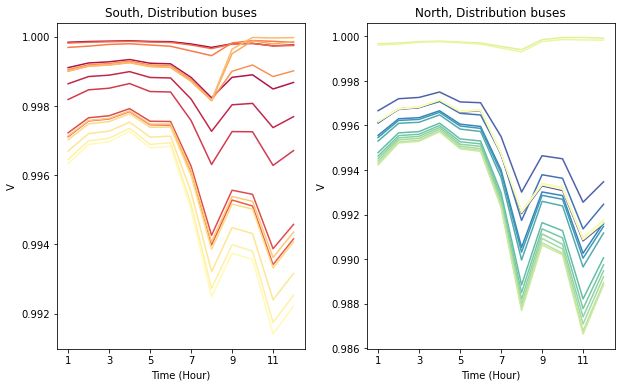

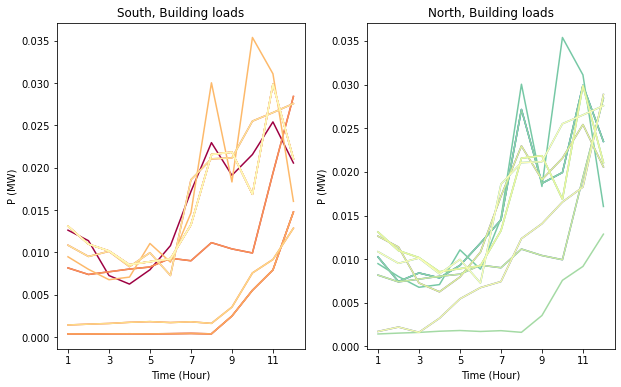

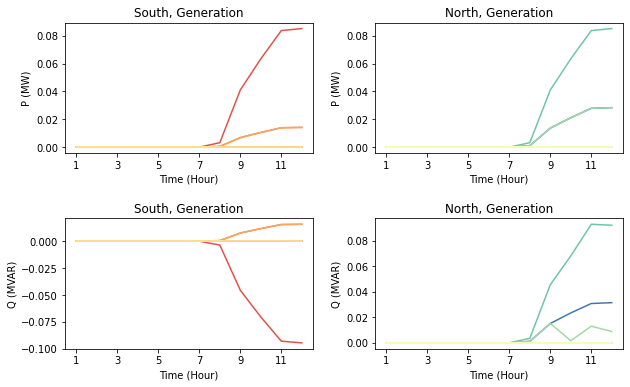

In [8]:
my_grid.plot_all()

In [9]:
from collections import Counter

houses_with_pv = [my_grid.buildings[i].building_type for i in my_grid.net.gen.name]
count_pv_houses = Counter(houses_with_pv)
for k,v in count_pv_houses.items():
    print(f"There is a PV generator at {v} houses of type {k}.")
    
# PV installed at buildings of type 2,3,7,8,9,10 are void since CityLearn doesn't implement PV there
# so the call to self.buildings[building of type (2,3,7,8,9,10)] sets the pandapower generator to sn_mva = 0
# for buildings of type 1,4,5 the rated power production should be set to > 0

There is a PV generator at 10 houses of type 5.
There is a PV generator at 2 houses of type 1.
There is a PV generator at 1 houses of type 3.
There is a PV generator at 2 houses of type 4.
